# Predicting Changes in the Zillow Home Value Index by Zip Code

In this notebook, I complete EDA of various Zillow data available by zip code, then build predictive models to estimate the probability that the Zillow Home Value Index (ZHVI) will change by *x* percent over the next *n* months for a given zip code. The resulting models may be a helpful tool for people considering selling their home in making decisions about when to sell over the next twelve months: sell now, wait three months, wait six months, wait a year, etc.

### Import Libraries

In [970]:
import pandas as pd
import matplotlib as plt
from functools import reduce
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

### Load Data

In [836]:
zhvi_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_Zhvi_SingleFamilyResidence.csv',encoding = "ISO-8859-1")

In [837]:
zhvi_rental_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_Zri_SingleFamilyResidenceRental.csv',encoding = "ISO-8859-1")

In [841]:
buyer_seller_index = pd.read_csv('/Users/philglazer/Desktop/zillow_data/BuyerSellerIndexCrossTime_Zip.csv',encoding = "ISO-8859-1")

In [842]:
# code to clean up date columns in the buyer_seller_index table; needed to be able to join with other tables on date
# ex: turns '2018-6' into '2018-06', '2017-2' into '2017-02', etc.

for c in buyer_seller_index.columns:
    if '-' in c:
        first_digit = c.split('-')[0]
        second_digit = c.split('-')[1]
        if int(second_digit) < 10:
            temp = '0' + str(second_digit)
            buyer_seller_index.rename(columns={c:first_digit+'-'+temp},inplace=True)
        #print(c.split('-')[1])
        

In [843]:
foreclosures_resales = pd.read_csv('/Users/philglazer/Desktop/zillow_data/SalesPrevForeclosed_Share_Zip.csv',encoding = "ISO-8859-1")

In [844]:
sale_price_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Sale_Prices_Zip.csv')

In [845]:
sale_counts_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Sale_Counts_Zip.csv')

In [846]:
median_listing_price_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_MedianListingPrice_AllHomes.csv',encoding = "ISO-8859-1")

In [847]:
median_listing_price_persqft_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_MedianListingPricePerSqft_AllHomes.csv',encoding = "ISO-8859-1")

In [848]:
percent_listings_price_reductions_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_PctOfListingsWithPriceReductions_AllHomes.csv',encoding = "ISO-8859-1")

In [849]:
median_percent_price_reductions_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_MedianPctOfPriceReduction_AllHomes.csv',encoding = "ISO-8859-1")

In [850]:
monthly_listings_allhomes_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/MonthlyListings_NSA_AllHomes_Zip.csv',encoding = "ISO-8859-1")

In [851]:
new_monthly_listings_nsa_allhomes_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/NewMonthlyListings_NSA_AllHomes_Zip.csv',encoding = "ISO-8859-1")

In [852]:
median_daily_listings_nsa_allhomes_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/MedianDailyListings_NSA_AllHomes_Zip.csv',encoding = "ISO-8859-1")

In [853]:
price_to_rent_ratio_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_PriceToRentRatio_AllHomes.csv',encoding = "ISO-8859-1")

#### List of data available

In [854]:
# used later to iterate over the data sets available

data_sets = [zhvi_data, zhvi_rental_data, foreclosures_resales, sale_price_data, sale_counts_data, median_listing_price_data, median_listing_price_persqft_data,
            percent_listings_price_reductions_data, median_percent_price_reductions_data, monthly_listings_allhomes_data,
            new_monthly_listings_nsa_allhomes_data, median_daily_listings_nsa_allhomes_data, price_to_rent_ratio_data]

In [855]:
# removed, mostly empty:'new_monthly_listings_nsa':new_monthly_listings_nsa_allhomes_data, 
# removed, mostly empty:'median_listing_price_persqft':median_listing_price_persqft_data,
# removed, mostly empty:'sale_price':sale_price_data, 
# removed, mostly empty:'sale_counts':sale_counts_data,



data_sets_dict = {
    'zhvi':zhvi_data,
    'zhvi_rental':zhvi_rental_data,
    'buyer_seller_index':buyer_seller_index,
    'foreclose_resales':foreclosures_resales,
    'median_listing_price':median_listing_price_data, 
    'percent_listing_price_reductions':percent_listings_price_reductions_data, 
    'median_percent_price_reductions':median_percent_price_reductions_data, 
    'monthly_listings_allhomes':monthly_listings_allhomes_data,
    'median_daily_listings':median_daily_listings_nsa_allhomes_data, 
    'price_to_rent_ratio':price_to_rent_ratio_data
}

In [856]:
zhvi_data.head(100)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,337200.0,338200.0,339000.0,...,1041900,1044100,1047700,1049600,1048500,1048500,1052700,1057800,1067100,1076100
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.0,212200.0,212200.0,...,336800,338100,338500,337200,336200,336100,335300,334000,333400,333200
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,502900.0,504900.0,506300.0,...,1320100,1320200,1319100,1318200,1319600,1322700,1328100,1334600,1340900,1342900
3,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,95400.0,95600.0,95800.0,...,177400,178100,178700,179600,180300,180900,181900,183200,182900,181500
4,93144,79936,El Paso,TX,El Paso,El Paso County,5,77300.0,77300.0,77300.0,...,123700,124600,125700,126400,126800,127500,128100,128600,128800,128800
5,91733,77084,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,6,95000.0,95200.0,95400.0,...,167500,168800,169700,170900,172400,173800,175500,177400,177500,175900
6,61807,10467,New York,NY,New York-Newark-Jersey City,Bronx County,7,151900.0,151800.0,151800.0,...,429300,433000,434000,434800,438000,442700,446400,450400,455000,458300
7,62037,11226,New York,NY,New York-Newark-Jersey City,Kings County,8,161800.0,162200.0,162500.0,...,1061600,1093500,1115700,1126900,1119900,1093800,1058200,1032400,1035700,1056900
8,84640,60640,Chicago,IL,Chicago-Naperville-Elgin,Cook County,9,218500.0,218500.0,218500.0,...,760700,756900,755900,748900,745600,749500,753500,756800,776100,799400
9,97564,94109,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,10,767700.0,772800.0,778000.0,...,3960500,3973400,3986000,4005300,4001400,4010700,4013400,3970000,3942000,3951300


### Helper Functions

In [857]:
# function that gets the row corresponding to a specific zip code from a given table
# the columns/rows need to be flipped, but the column names are dropped before the table is transposed
# resulting output is a dataframe with columns for date and value for a given zipcode and given data table


col_names = ['RegionID','RegionName','StateName','SizeRank','RegionType',
            'City','County','State','Metro','CountyName']

def prepare_df_for_zip(zip_code, data_set):
    data = data_set[data_set['RegionName']==zip_code]
    for c in col_names:
        if c in data.columns:
            data.drop([c],axis=1,inplace=True)
    data = data.transpose()
    data['Date'] = data.index
    return data[data['Date']>='2010-01'] #.add_prefix('hello')
    

In [858]:
prepare_df_for_zip(79936, zhvi_data).head()

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,4,Date
2010-01,117300.0,2010-01
2010-02,117300.0,2010-02
2010-03,116900.0,2010-03
2010-04,116100.0,2010-04
2010-05,115700.0,2010-05


In [985]:
# function that iterates over the data sets available and applies prepare_df_for_zip to each and stores the results of each call
# after gathering all data for a given zipcode, the function joins the data on date to return a dataframe

def join_data_available(zip_code, data_sets):
    master_df = pd.DataFrame()
    df_list = []
    for k in data_sets_dict.keys():
        data = prepare_df_for_zip(zip_code, data_sets_dict[k])#.add_prefix(k)
        for i in range(1750):
                data.rename(columns={i:k}, inplace=True)
        df_list.append(data)        
        
    df_final = reduce(lambda left,right: pd.merge(left,right,on='Date'), df_list)
    return df_final
    
    #df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['DATE'],how='outer'), data_frames)


In [995]:
join_data_available(77449, data_sets_dict)

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,zhvi,Date,zhvi_rental,buyer_seller_index,foreclose_resales,median_listing_price,percent_listing_price_reductions,median_percent_price_reductions,monthly_listings_allhomes,median_daily_listings,price_to_rent_ratio
0,117300.0,2013-01,1258.0,1.47,0.0795,129997.5,7.797271,4.074795,479.0,337.0,8.10
1,117900.0,2013-02,1258.0,2.06,0.0909,136316.0,5.709024,3.032141,489.0,372.0,8.07
2,118400.0,2013-03,1265.0,2.45,0.0220,138995.0,6.188925,2.704027,541.0,396.0,8.09
3,119300.0,2013-04,1277.0,2.25,0.0154,140000.0,4.657933,3.466128,605.0,392.0,8.11
4,120500.0,2013-05,1297.0,2.55,0.0161,141905.0,7.294430,2.515723,701.0,472.0,8.06
5,121700.0,2013-06,1310.0,3.14,0.0325,142000.0,7.133059,2.238806,646.0,464.0,8.12
6,123000.0,2013-07,1324.0,3.53,0.0170,144900.0,9.090909,2.605142,605.0,384.0,8.02
7,124400.0,2013-08,1326.0,6.27,0.0063,149000.0,10.968661,2.849068,575.0,416.0,7.95
8,125500.0,2013-09,1333.0,5.69,0.0000,150495.0,9.948542,2.796778,515.0,390.0,8.03
9,126200.0,2013-10,1335.0,5.39,0.0265,156000.0,8.658744,3.126954,518.0,350.0,8.06


In [1005]:
# code that takes in a zip_code and loads all available data, then performs train/test split and model fitting with a 
# random forest classifier

def run_full_model(zip_code, target_col):
    data = join_data_available(zip_code, data_sets_dict).set_index('Date')
    
    # converts object type to float to take as a model input
    data["buyer_seller_index"] = data["buyer_seller_index"].astype(float)
    
    scaler = StandardScaler()
    data[['median_listing_price',
     'percent_listing_price_reductions',
     'median_percent_price_reductions',
     'monthly_listings_allhomes',
     'median_daily_listings',
     'price_to_rent_ratio']] = scaler.fit_transform(data[['median_listing_price',
     'percent_listing_price_reductions',
     'median_percent_price_reductions',
     'monthly_listings_allhomes',
     'median_daily_listings',
     'price_to_rent_ratio']])
    
    data['zhvi_+3mo'] = data['zhvi'].shift(-3)
    data['zhvi_+6mo'] = data['zhvi'].shift(-6)
    data['zhvi_+9mo'] = data['zhvi'].shift(-9)
    data['zhvi_+12mo'] = data['zhvi'].shift(-12)

    data['pct_change_3mo'] = (data['zhvi_+3mo'] - data['zhvi'])/data['zhvi']
    data['pct_change_6mo'] = (data['zhvi_+6mo'] - data['zhvi'])/data['zhvi']
    data['pct_change_9mo'] = (data['zhvi_+9mo'] - data['zhvi'])/data['zhvi']
    data['pct_change_12mo'] = (data['zhvi_+12mo'] - data['zhvi'])/data['zhvi']

    data['positive_3mo_change'] = data['pct_change_3mo'].apply(lambda x: 1 if x>0 else 0)
    data['positive_6mo_change'] = data['pct_change_6mo'].apply(lambda x: 1 if x>0 else 0)
    data['positive_9mo_change'] = data['pct_change_9mo'].apply(lambda x: 1 if x>0 else 0)
    data['positive_12mo_change'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0 else 0)
    
    data['two_percent_plus_12mo'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0.02 else 0)
    data['five_percent_plus_12mo'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0.05 else 0)
    data['ten_percent_plus_12mo'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0.1 else 0)
    
    # some NaN values after this date
    data = data[data.index<'2018-05']
    
    # make this an input variable
    # testing removal of features:'zhvi','zhvi_rental',
    features = data[[
     'buyer_seller_index',
     'median_listing_price',
     'percent_listing_price_reductions',
     'median_percent_price_reductions',
     'monthly_listings_allhomes',
     'median_daily_listings',
     'price_to_rent_ratio']]
    
    #,'foreclose_resales' -> removed, values only current through 2019-01
    
    #,'buyer_seller_index' -> removed, data type caused an XGBoost error?
    
    # make this an input variable
    target = data[target_col]
    
    # adjust to deal with date range
    features = features[features.index>='2013-01']
    target = target #[12:]
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)
    
    
    # Random Classifier Fitting
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    
    print(clf.feature_importances_)
    
    y_pred = clf.predict(X_test)
    #y_proba = pd.DataFrame(clf.predict_proba(X_test))[1]
    
    print("---------")
    print("Predicting " + target_col + "...")
    print("Random Forest F1 Score:",f1_score(y_test, y_pred, average='weighted'))
    random_forest_f1 = f1_score(y_test, y_pred, average='weighted')
    print(pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result']))
    
    # XGBoost Classifier
    model = XGBClassifier(scale_pos_weight=1,learning_rate=0.3,
                      colsample_bytree=0.4,subsample=0.8,objective='binary:logistic',
                     n_estimators=100,reg_alpha=0.3,max_depth=6,gamma=10)
    model.fit(X_train, y_train)
    xgboost_predictions = model.predict(X_test)
    pd.crosstab(y_test, xgboost_predictions, rownames=['Actual Result'], colnames=['Predicted Result'])
    print("XGBoost F1 Score:",f1_score(y_test, xgboost_predictions, average='weighted'))
    print(pd.crosstab(y_test, xgboost_predictions, rownames=['Actual Result'], colnames=['Predicted Result']))
    xgboost_f1 = f1_score(y_test, xgboost_predictions, average='weighted')
    
    if random_forest_f1>=xgboost_f1:
        return clf
    else:
        return model
    
    data['zhvi'].plot()
    
    #return data [77449, 37013, 37042, 77479]
    
    #good_zips2 = [60629, 78704, 75287, 30024, 78745, 28027,48197, 66062, 95630, 90044, 90805]

In [1006]:
run_full_model(77449, 'five_percent_plus_12mo')

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.15409266 0.1064417  0.13620152 0.03957828 0.12202687 0.20330032
 0.23835866]
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9564213564213564
Predicted Result  0   1
Actual Result          
0                 4   0
1                 1  17
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### Iterate Over Predictions

In [1002]:
prediction_list = ['positive_3mo_change', 'positive_6mo_change', 'positive_12mo_change', 'two_percent_plus_12mo', 
                  'five_percent_plus_12mo', 'ten_percent_plus_12mo']

# iterate over a list of types of predictions and show the results for each
def iterate_over_predictions(zip_code, prediction_list):
    for p in prediction_list:
        print(run_full_model(zip_code,p))

In [1009]:
# iterate over a list of types of predictions and get the best model for each prediction, save to a [dictionary]?

def gather_models_zip(zip_code, prediction_list):
    models_dict = {}
    for p in prediction_list:
        models_dict[p] = run_full_model(zip_code,p)
    return models_dict

In [1010]:
gather_models_zip(77494, prediction_list)

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.31806897 0.0549442  0.14948799 0.03701764 0.07307767 0.15223911
 0.21516443]
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.9526695526695526
Predicted Result  0   1
Actual Result          
0                 4   1
1                 0  17
XGBoost F1 Score: 0.6736596736596737
Predicted Result   1
Actual Result       
0                  5
1                 17


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.35351473 0.07952628 0.05824746 0.09667748 0.10822902 0.07365014
 0.23015489]
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 4   0
1                 0  18
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.33582065 0.07782843 0.03485946 0.16836697 0.09124368 0.05235119
 0.23952962]
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8715338715338716
Predicted Result  0   1
Actual Result          
0                 2   1
1                 2  17
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.29773204 0.11190981 0.06350553 0.11983203 0.08527267 0.04012233
 0.28162559]
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.8053475935828878
Predicted Result  0   1
Actual Result          
0                 3   3
1                 1  15
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.31954668 0.12658443 0.11807664 0.04878831 0.06808655 0.03051754
 0.28839986]
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9546395633352156
Predicted Result   0   1
Actual Result           
0                 10   0
1                  1  11
XGBoost F1 Score: 0.8627893845285151
Predicted Result   0  1
Actual Result          
0                 10  0
1                  3  9


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.02855022 0.12096558 0.20021013 0.03997154 0.0717228  0.02489801
 0.12368172]
---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
XGBoost F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



{'positive_3mo_change': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 'positive_6mo_change': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 'positive_12mo_change': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2,

In [1014]:
# iterate over a list of zip codes and get the models for each prediction in prediction list
# combine the models dictionary for each zip code into a master dictionary

def gather_models_list_of_zips(list_of_zips, prediction_list):
    master_dict = {}
    for l in list_of_zips:
        data = gather_models_zip(l,prediction_list)
        master_dict[l] = data
    
    return master_dict

In [1015]:
good_zips = [77449, 37013, 37042, 77479]

output = gather_models_list_of_zips(good_zips, prediction_list)

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.10330616 0.06614922 0.11085164 0.0702511  0.2999063  0.23961389
 0.10992169]
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.8886363636363637
Predicted Result  0   1
Actual Result          
0                 1   2
1                 0  19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.15237385 0.10192589 0.12042026 0.05704111 0.23179548 0.176949
 0.15949441]
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.13369748 0.09462559 0.25661011 0.11743327 0.06255043 0.07254638
 0.16253674]
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 1   0
1                 0  21
XGBoost F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.17648846 0.15593059 0.26551222 0.0798911  0.06313472 0.06956952
 0.18947338]
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.9475240206947523
Predicted Result  0   1
Actual Result          
0                 1   1
1                 0  20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.15409266 0.1064417  0.13620152 0.03957828 0.12202687 0.20330032
 0.23835866]
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9564213564213564
Predicted Result  0   1
Actual Result          
0                 4   0
1                 1  17
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.33086007 0.21912734 0.06444849 0.06102567 0.05246309 0.06621154
 0.2058638 ]
---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.7658402203856749
Predicted Result   0  1
Actual Result          
0                 14  2
1                  3  3
XGBoost F1 Score: 0.8053475935828878
Predicted Result   0  1
Actual Result          
0                 15  1
1                  3  3


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0. 0. 0. 0. 0. 0. 0.]
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0. 0. 0. 0. 0. 0. 0.]
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0. 0. 0. 0. 0. 0. 0.]
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0. 0. 0. 0. 0. 0. 0.]
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0. 0. 0. 0. 0. 0. 0.]
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.10418796 0.28852019 0.0344558  0.02459488 0.17419485 0.1063215
 0.26772481]
---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.9542583732057417
Predicted Result  0   1
Actual Result          
0                 9   1
1                 0  12
XGBoost F1 Score: 0.9542583732057417
Predicted Result  0   1
Actual Result          
0                 9   1
1                 0  12


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.06890525 0.13398226 0.28662752 0.12230862 0.0763358  0.1063531
 0.20548745]
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7365967365967365
Predicted Result  0   1
Actual Result          
0                 6   1
1                 5  10
XGBoost F1 Score: 0.7801544860368389
Predicted Result  0   1
Actual Result          
0                 6   1
1                 4  11


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.1522281  0.07859916 0.34194477 0.11878304 0.07743816 0.11816525
 0.11284153]
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8181818181818182
Predicted Result  0   1
Actual Result          
0                 6   2
1                 2  12
XGBoost F1 Score: 0.494949494949495
Predicted Result   1
Actual Result       
0                  8
1                 14


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.22916267 0.1889636  0.11361163 0.08211502 0.18651752 0.16380747
 0.0358221 ]
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8755244755244757
Predicted Result  0   1
Actual Result          
0                 1   1
1                 2  18
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.0885857  0.30319216 0.17086362 0.0090725  0.156837   0.14048673
 0.13096229]
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   0   1
Actual Result           
0                 11   0
1                  0  11
XGBoost F1 Score: 1.0
Predicted Result   0   1
Actual Result           
0                 11   0
1                  0  11


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.19648142 0.29209166 0.12433287 0.0436542  0.13032636 0.12208397
 0.09102953]
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.951912951912952
Predicted Result   0  1
Actual Result          
0                 18  0
1                  1  3
XGBoost F1 Score: 0.951912951912952
Predicted Result   0  1
Actual Result          
0                 18  0
1                  1  3


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0. 0. 0. 0. 0. 0. 0.]
---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   0
Actual Result       
0                 22
XGBoost F1 Score: 1.0
Predicted Result   0
Actual Result       
0                 22


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.19473617 0.10639839 0.06196964 0.09988552 0.14479189 0.09828771
 0.2939307 ]
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.23910521 0.15360077 0.09531932 0.06505488 0.11499501 0.11876717
 0.21315764]
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.2342915  0.20846975 0.10325439 0.05665702 0.12138483 0.1460784
 0.12986411]
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 1   0
1                 0  21
XGBoost F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.2956263  0.02187858 0.06824495 0.02878169 0.1405002  0.16199735
 0.28297093]
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 8   0
1                 0  14
XGBoost F1 Score: 0.9550406020994257
Predicted Result  0   1
Actual Result          
0                 8   0
1                 1  13


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.30830437 0.03071023 0.07268913 0.02972655 0.1111658  0.13147888
 0.31592505]
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 9   0
1                 0  13
XGBoost F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 9   0
1                 0  13


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.14868078 0.16823364 0.05025889 0.06717837 0.12606805 0.15548134
 0.28409894]
---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.9538140020898641
Predicted Result   0  1
Actual Result          
0                 14  0
1                  1  7
XGBoost F1 Score: 0.494949494949495
Predicted Result   0
Actual Result       
0                 14
1                  8


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.31806897 0.0549442  0.14948799 0.03701764 0.07307767 0.15223911
 0.21516443]
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.9526695526695526
Predicted Result  0   1
Actual Result          
0                 4   1
1                 0  17
XGBoost F1 Score: 0.6736596736596737
Predicted Result   1
Actual Result       
0                  5
1                 17
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.35351473 0.07952628 0.05824746 0.09667748 0.10822902 0.07365014
 0.23015489]
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 4   0
1                 0  18
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.33582065 0.07782843 0.03485946 0.16836697 0.09124368 0.05235119
 0.23952962]
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8715338715338716
Predicted Result  0   1
Actual Result          
0                 2   1
1                 2  17
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.29773204 0.11190981 0.06350553 0.11983203 0.08527267 0.04012233
 0.28162559]
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.8053475935828878
Predicted Result  0   1
Actual Result          
0                 3   3
1                 1  15
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.31954668 0.12658443 0.11807664 0.04878831 0.06808655 0.03051754
 0.28839986]
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9546395633352156
Predicted Result   0   1
Actual Result           
0                 10   0
1                  1  11
XGBoost F1 Score: 0.8627893845285151
Predicted Result   0  1
Actual Result          
0                 10  0
1                  3  9
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.02855022 0.12096558 0.20021013 0.03997154 0.0717228  0.02489801
 0.12368172]
---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
XGBoost F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



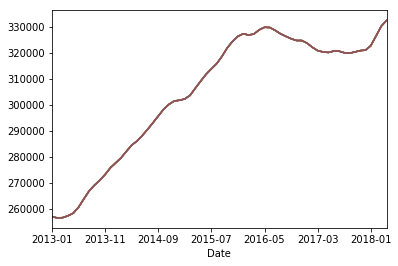

In [1004]:
iterate_over_predictions(77494, prediction_list)

In [923]:
# write a function that finds the area codes that have data that works

def check_zip(zip_code, start_date, end_date):
    data = join_data_available(zip_code, data_sets_dict)
    data = data[data['Date']>=start_date] 
    data = data[data['Date']<=end_date]
    
    for c in data.columns:
        if data[c].isnull().sum() > 0:
            return False
    
    features = ['foreclose_resales',
     'median_listing_price',
     'percent_listing_price_reductions',
     'median_percent_price_reductions',
     'monthly_listings_allhomes',
     'median_daily_listings',
     'price_to_rent_ratio']
    
    for f in features:
        if f not in data.columns:
            return False
    
    return True

In [926]:
check_zip(10467,'2013-12','2019-01')

False

In [927]:
def check_list_of_zips(list_of_zips, start_date, end_date):
    i = 0
    good_zips = []
    for l in list_of_zips:
        if check_zip(l,start_date,end_date):
            good_zips.append(l)
        print(i)
        i+=1
    return good_zips

In [961]:
#check_list_of_zips(list(zhvi_data['RegionName'][100:150]), '2013-12','2019-01')

In [938]:
good_zips = [77449, 37013, 37042, 77479, 30044]

good_zips2 = [60629, 78704, 75287, 30024, 78745, 28027,
              48197, 66062, 95630, 90044, 90805]

Predicting for: 60629...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.9475240206947523
Predicted Result  0   1
Actual Result          
0                 1   1
1                 0  20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9026737967914439
Predicted Result  0   1
Actual Result          
0                 4   2
1                 0  16
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
XGBoost F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
None
Predicting for: 78704...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.8886363636363637
Predicted Result  0   1
Actual Result          
0                 1   2
1                 0  19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.9090909090909091
Predicted Result   0  1
Actual Result          
0                 20  1
1                  1  0
XGBoost F1 Score: 0.9323467230443975
Predicted Result   0
Actual Result       
0                 21
1                  1
None
Predicting for: 75287...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21
XGBoost F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.7069147069147068
Predicted Result  0   1
Actual Result          
0                 1   5
1                 0  16
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.827972027972028
Predicted Result   0  1
Actual Result          
0                 18  0
1                  3  1
XGBoost F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
None
Predicting for: 30024...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.9090909090909091
Predicted Result   0  1
Actual Result          
0                 19  1
1                  1  1
XGBoost F1 Score: 0.8658008658008658
Predicted Result   0
Actual Result       
0                 20
1                  2
None
Predicting for: 78745...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21
XGBoost F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.9090909090909091
Predicted Result   0  1
Actual Result          
0                 13  1
1                  1  7
XGBoost F1 Score: 0.8614420062695924
Predicted Result   0  1
Actual Result          
0                 13  1
1                  2  6
None
Predicting for: 28027...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.7772727272727273
Predicted Result  0   1
Actual Result          
0                 0   3
1                 1  18
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9542583732057417
Predicted Result  0   1
Actual Result          
0                 9   1
1                 0  12
XGBoost F1 Score: 0.859180035650624
Predicted Result  0   1
Actual Result          
0                 7   3
1                 0  12
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   0
Actual Result       
0                 22
XGBoost F1 Score: 1.0
Predicted Result   0
Actual Result       
0                 22
None
Predicting for: 48197...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.7992424242424243
Predicted Result   0  1
Actual Result          
0                 14  0
1                  4  4
XGBoost F1 Score: 0.494949494949495
Predicted Result   0
Actual Result       
0                 14
1                  8
None
Predicting for: 66062...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

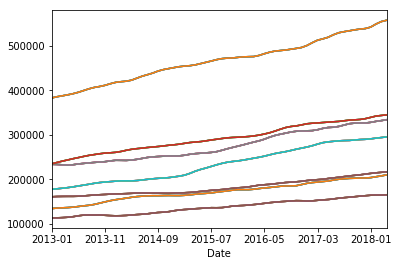

In [939]:
for g in good_zips2:
    print("Predicting for: " + str(g) + "...")
    iterate_over_predictions(g)

### Good Zip Codes

In [822]:
# Works for capturing positive/negative at various month buckets:
# 28269, <'2018-10', all start date -> monotonically increasing
# 32162, <'2018-10', all start date
# 20002, <'2018-10', all start date -> monotonically increasing
# 28027, <'2018-10', all start date -> almost entirely monotonically increasing

# 37013, monotonically increasing

# 79936, <'2018-10', all start date


# 77494

# Works for capturing 2/5/10 percent plus increases
